## Imports

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re

## Carregando a base de dados

O Arquivo Json do dataset é disponibilizado em: [Kaggle](https://www.kaggle.com/datasets/jojojmo/reviews-enigma-do-medo-20-12-2024)

In [90]:
data_path = r"..\data\reviews_processed_llm.json"

df = pd.read_json(data_path, encoding='utf-8')

In [91]:
columns = ['quantidade_premios', 'votos_review', 'avaliacao', 'horas_jogadas', 'data_publicacao', 'texto_processado',"recebeu_gratis"]

df = df[columns]

In [92]:
df.head()

,quantidade_premios,votos_review,avaliacao,horas_jogadas,data_publicacao,texto_processado,recebeu_gratis
0,0,No one has rated this review as helpful yet,Recommended,37.4 hrs on record,Posted: 20 December,A investigação é incrível e a história é absur...,No received
1,0,No one has rated this review as helpful yet,Recommended,21.0 hrs on record,Posted: 20 December,Eu aguardei por muito tempo para jogar esse jo...,No received
2,0,No one has rated this review as helpful yet,Recommended,5.1 hrs on record,Posted: 20 December,"Gosto da ambientação, enigmas e personagens, a...",No received
3,0,No one has rated this review as helpful yet,Recommended,3.3 hrs on record,Posted: 20 December,"Compatibilidade péssima, mas... ordem paranorm...",No received
4,0,No one has rated this review as helpful yet,Recommended,34.1 hrs on record,Posted: 20 December,"A estética do jogo é simplesmente incrível, co...",No received


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   quantidade_premios  6535 non-null   int64 
 1   votos_review        6535 non-null   object
 2   avaliacao           6535 non-null   object
 3   horas_jogadas       6535 non-null   object
 4   data_publicacao     6535 non-null   object
 5   texto_processado    6535 non-null   object
 6   recebeu_gratis      6535 non-null   object
dtypes: int64(1), object(6)
memory usage: 357.5+ KB


In [6]:
df.describe()

,quantidade_premios
count,6535.000000
mean,0.054476
std,0.703810
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,35.000000


Como os dados vieram de uma raspagem de dados, certos vestígios de texto fazem a tipagem das features estarem todas como `object`. Para limpar os dados, será utilizado certos tratamentos e uso de excpressões regulares.

## Tratamentos

Ajuste na formatação e tipagem de `data_publicacao` para que seja DateTime

In [93]:
def ajust_data(row: str) -> pd.Timestamp:
    """
    Converte uma string de data em um objeto datetime do pandas, tentando diferentes formatos.

    Parâmetros:
    row (str): Uma string representando uma data em um dos seguintes formatos:
               - '%d %B %Y' (ex.: '25 December 2023')
               - '%B %d %Y' (ex.: 'December 25 2023')

    Retorno:
    pd.Timestamp: Um objeto datetime convertido a partir da string fornecida.
                  Caso a conversão falhe, retorna `NaT` (Not a Time).
    """
    try:
        return pd.to_datetime(row, format='%d %B %Y')
    except:
        return pd.to_datetime(row, format='%B %d %Y', errors="coerce")




series_data = df["data_publicacao"].apply(lambda x: x.replace("Posted: ", "") + ' 2024')
df["data_publicacao"] = series_data.apply(ajust_data)

Ao analisar a feature `votos_review`, se observa que o conteúdo dela se divide em:

- Reviews que ainda não foram úteis
- Reviews úteis
- Reviews não útesi mas engraçadas (ùtil:0, Engraçada: 999)
- Reviews engraçadas e úteis

Ao entender isso, se pode abordar o tratamento da feature sendo a criação de duas novas colunas: `review_util`, `review_engracado`. Para fazer isso, será utilizado Regex e outros tratamentos lógicos.

In [94]:
df["votos_review"].value_counts()

votos_review
No one has rated this review as helpful yet                                    5102
1 person found this review helpful                                              883
2 people found this review helpful                                              154
No one has rated this review as helpful yet1 person found this review funny      83
3 people found this review helpful                                               42
                                                                               ... 
204 people found this review helpful11 people found this review funny             1
3 people found this review helpful10 people found this review funny               1
53 people found this review helpful29 people found this review funny              1
115 people found this review helpful6 people found this review funny              1
13 people found this review helpful7 people found this review funny               1
Name: count, Length: 104, dtype: int64

Aplicação das funções para criar as features `review_util` e `review_engracado`.

In [95]:

# Retorna 3 grupos
pattern_votos_review = re.compile(r"(^\d*)|(((?<=helpful)\d*)|(?<=yet)\d*)", re.DOTALL | re.MULTILINE)

#Operador OR negativo: Só é falso quando os dois são verdadeiros
NEGATIVE_OR = lambda p, q: not p or not q


def fill_matches(row):
    """
    Preenche um array com valores extraídos de um padrão regex `pattern_votos_review` aplicado a uma string.

    Parâmetros:
    row (str): A string contendo os dados onde o padrão regex será aplicado.

    Retorno:
    list: Uma lista de inteiros com três elementos, onde cada elemento representa um valor correspondente 
          encontrado pelos grupos da regex. Caso não encontre, será preenchido com 0.
    """
    array = [0, 0, 0]
    matches = re.finditer(pattern_votos_review, row)
    for i, match in enumerate(matches):
        if match.group(0) != '':
            array[i] = int(match.group(0))
    return array

def make_array(array):
    """
    Constrói um array a partir de um array de entrada, aplicando condições lógicas para validá-lo.

    Parâmetros:
    array (list): Lista de inteiros onde:
                  - O primeiro elemento representa votos gerais.
                  - O segundo e terceiro elementos representam votos específicos (ex.: úteis, engraçados).

    Retorno:
    list: Uma nova lista com o primeiro elemento seguido pelos elementos válidos dos índices 1 e 2.
          Caso não existam valores válidos em 1 e 2, retorna [0] no lugar.

    Exceção:
    ValueError: Levantada se os elementos dos índices 1 e 2 possuírem valores diferentes de zero ao mesmo tempo.
    """
    if NEGATIVE_OR(array[1] != 0, array[2] != 0):
        filter_elements = list(filter(lambda x: x != 0, array[1:]))
        return [array[0]] + (filter_elements or [0]) # Retora [<int>, <int>] ou [0]
    raise ValueError("Not support regex group 2 and group 3 having values at the same time")


def reviews_apply(row) -> pd.DataFrame:
    """
    Aplica a lógica de extração e transformação em uma linha específica de um DataFrame.

    Parâmetros:
    row (str): A string representando os votos de review em um formato específico.

    Retorno:
    pandas.Series: Uma série contendo os valores extraídos e processados da string, com colunas como:
                   - 'review_util': Votos úteis extraídos da string.
                   - 'review_engracado': Votos engraçados extraídos da string.
    """
    array = fill_matches(row)
    return pd.Series(make_array(array))

# Aplicação no DataFrame
df[["review_util", "review_engracado"]] = df["votos_review"].apply(reviews_apply)


Tratemnto simples em horas jogadas

In [96]:
df["horas_jogadas"] = df["horas_jogadas"].apply(lambda x: x.replace(" hrs on record", "")).astype(float)

Binarização da feature `recebeu_gratis`, sendo 1 para a classe "Sim" e 0 para "Não".

In [97]:
df["recebeu_gratis"] = df["recebeu_gratis"].apply(lambda x: 1 if x == "Product received for free" else 0)

Criação de `label` a classe que representa 1 como "Recomendado" e 0 para "Não recomendado".

In [98]:
df["label"] = 0
df.loc[df["avaliacao"] == "Recommended","label"] = 1

DataFrame com suas tipagens e dados devidamente tratatos

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   quantidade_premios  6535 non-null   int64         
 1   votos_review        6535 non-null   object        
 2   avaliacao           6535 non-null   object        
 3   horas_jogadas       6535 non-null   float64       
 4   data_publicacao     6535 non-null   datetime64[ns]
 5   texto_processado    6535 non-null   object        
 6   recebeu_gratis      6535 non-null   int64         
 7   review_util         6535 non-null   int64         
 8   review_engracado    6535 non-null   int64         
 9   label               6535 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 510.7+ KB


In [14]:
df

,quantidade_premios,votos_review,avaliacao,horas_jogadas,data_publicacao,texto_processado,recebeu_gratis,review_util,review_engracado,label
0,0,No one has rated this review as helpful yet,Recommended,37.4,2024-12-20,A investigação é incrível e a história é absur...,0,0,0,1
1,0,No one has rated this review as helpful yet,Recommended,21.0,2024-12-20,Eu aguardei por muito tempo para jogar esse jo...,0,0,0,1
2,0,No one has rated this review as helpful yet,Recommended,5.1,2024-12-20,"Gosto da ambientação, enigmas e personagens, a...",0,0,0,1
3,0,No one has rated this review as helpful yet,Recommended,3.3,2024-12-20,"Compatibilidade péssima, mas... ordem paranorm...",0,0,0,1
4,0,No one has rated this review as helpful yet,Recommended,34.1,2024-12-20,"A estética do jogo é simplesmente incrível, co...",0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6530,0,5 people found this review helpful,Recommended,0.3,2024-11-28,Jogo do Selvagem. O Jogo do Selvagem (ou Selva...,0,5,0,1
6531,0,13 people found this review helpful7 people fo...,Recommended,3.0,2024-11-28,Esse jogo é tão bom que não consigo deixar de ...,0,13,7,1
6532,0,2 people found this review helpful,Recommended,40.7,2024-11-28,Enigma do Medo é um jogo incrível e eu recomen...,0,2,0,1
6533,0,3 people found this review helpful,Recommended,33.9,2024-11-28,Os Melhores Jogos de 2025: uma previsão,0,3,0,1


In [15]:
df.describe()

,quantidade_premios,horas_jogadas,data_publicacao,recebeu_gratis,review_util,review_engracado,label
count,6535.000000,6535.000000,6535,6535.000000,6535.000000,6535.000000,6535.000000
mean,0.054476,22.738898,2024-12-03 17:57:44.483549952,0.015149,1.162357,0.127314,0.964193
min,0.000000,0.100000,2024-11-28 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.500000,2024-11-29 00:00:00,0.000000,0.000000,0.000000,1.000000
50%,0.000000,22.800000,2024-12-02 00:00:00,0.000000,0.000000,0.000000,1.000000
75%,0.000000,30.200000,2024-12-07 00:00:00,0.000000,0.000000,0.000000,1.000000
max,35.000000,385.600000,2024-12-20 00:00:00,1.000000,521.000000,115.000000,1.000000
std,0.703810,14.699218,NaN,0.122156,13.801119,2.098802,0.185823


## Alguns Insights

Os dados são majoritariamente de pessoas que não reberam suas cópias de jogos gratuitamente.

In [83]:
recebeu_gratis = dict(df["recebeu_gratis"].value_counts())

percentual_positivas = (recebeu_gratis[0] - recebeu_gratis[1]) / len(df)

print(f"Recebeu Grátis: {round(percentual_positivas,4) * 100}%")

Recebeu Grátis: 96.97%


A avaliação é muito positiva para os dados que tiveram o procesamento e limpeza ortográfica da llama3.1

In [82]:
avaliacoes = dict(df["avaliacao"].value_counts())

percentual_positivas = (avaliacoes["Recommended"] - avaliacoes["Not Recommended"]) / len(df)

print(f"Avaliações: {round(percentual_positivas,4) * 100}%")

Avaliações: 92.84%


Se for somado todas as horas jogadas das pessoas que fizeram no exato momento que fizeram a review, o tempo total seria de 16 anos.

In [99]:
import datetime


total_horas = df["horas_jogadas"].sum()

horas = int(total_horas)
minutos = int((total_horas - horas) * 60)
segundos = int(((total_horas - horas) * 60 - minutos) * 60)

total_dias = total_horas / 24
total_anos = int(total_dias / 365.25)

tempo_total = datetime.timedelta(hours=horas, minutes=minutos, seconds=segundos)

# Exibindo o tempo total
print(f"Horas totais jogadas: {str(tempo_total)}")
print(f"Tempo total em anos jogados: {total_anos} anos")


Horas totais jogadas: 6191 days, 14:42:00
Tempo total em anos jogados: 16 anos


Em média, os jogadores fizeram sua review com 22 horas de jogo. Segundo um dos criadores, é previsto que se conclua a campanha entre 20 a 30 horas de jogo, isso quer dizer que a maioria das pessoas que fez a review, terminou o jogo antes de fazer sua avaliação.

In [20]:
print(f"Média de horas jogadas: {round(df["horas_jogadas"].mean(), 2)}")

Média de horas jogadas: 22.74


Os dados processados pela llama3.1 concentram grande parte dos votos das reviews como úteis ao invés de engraçadas.

In [21]:
print(f"Total de reviews úteis: {df["review_util"].sum()}")

Total de reviews úteis: 7596


In [22]:
print(f"Total de reviews engraçadas: {df["review_engracado"].sum()}")

Total de reviews engraçadas: 832


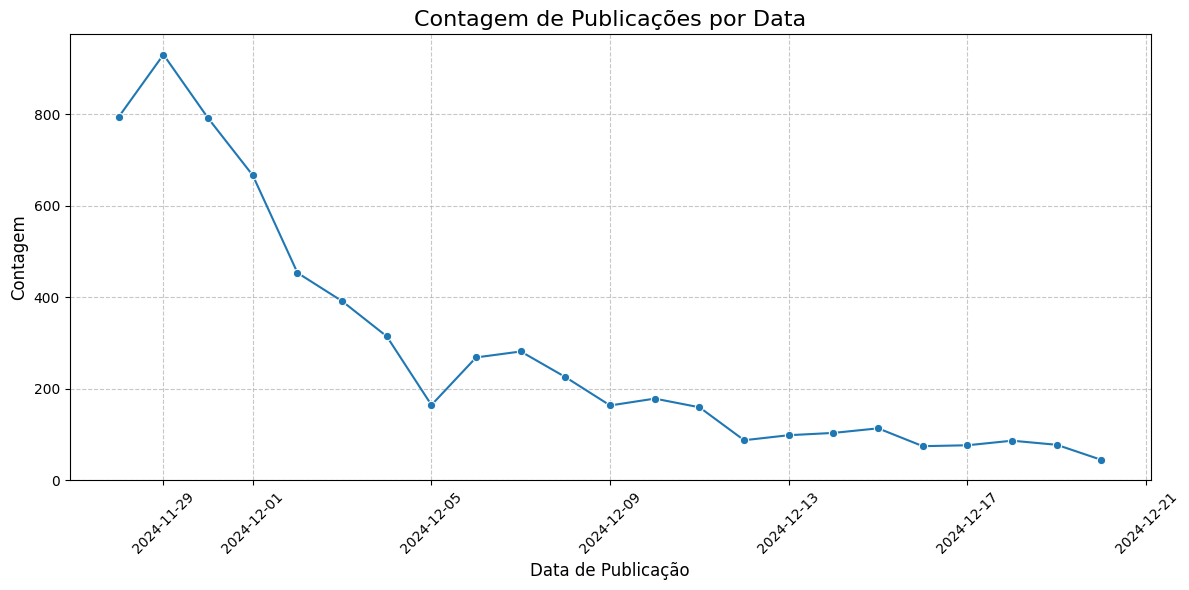

In [23]:
series_dt_publi = df["data_publicacao"].value_counts().sort_index()

# Criando o gráfico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot( x=series_dt_publi.index, 
             y=series_dt_publi.values, 
             marker="o")

# Personalizando o gráfico
plt.title("Contagem de Publicações por Data", fontsize=16)
plt.xlabel("Data de Publicação", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Ao ler o gráfico, se nota que as reviews ao longo do tempo foram diminuindo, em um ritmo quase constante, leves picos, mas sempre com a tendência de diminuir. Um dos motivos que pode causar esse acontecimento é a diminuição na venda do jogo.

## Clusterização

Para construir os Clusters utilizando o método de Pipelines do sklearn, foi preciso desenvolver classes de normalização antes.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertDatesToNumeric(BaseEstimator, TransformerMixin):
    """
    Transformador para converter datas em números.

    Atributos:
    None
    """
    def __init__(self, col):
        self.col = col

    def transform(self, X):
        """
        Converte as colunas de data do DataFrame em números.

        Utiliza as 'online_date_convert' e 'expires_at' em específico.

        Parâmetros:
        X (pandas.DataFrame): O DataFrame de entrada.

        Retorna:
        X (pandas.DataFrame): O DataFrame com as colunas de data convertidas em números.
        """
        X[self.col] = X[self.col].astype('int64') // 10**9  # Converter para Unix timestamp
        return X

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados.

        Não há ajuste necessário nesse transformador, pois apenas converte datas em números.

        Parâmetros:
        X (pandas.DataFrame): Os dados de entrada.
        y (opcional): Não é utilizado nesse transformador.

        Retorna:
        self: O transformador ajustado.
        """
        return self

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer

class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
        """
        Normaliza dados textuais com embbeding e retorna o vetor dessa transformação.
        :param model_name: Nome do modelo a ser carregado (default é 'paraphrase-MiniLM-L6-v2').
        """
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        """
        Apenas retorna a própria instância
        """
        return self

    def transform(self, X):
        """
        Converte uma lista de textos em embeddings utilizando o modelo carregado.
        :param X: Lista de textos ou coluna de DataFrame.
        :return: Embeddings gerados pelo modelo.
        """
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0].tolist()  # Converte a coluna para uma lista de textos
        elif isinstance(X, pd.Series):
            X = X.tolist()  # Converte a série para uma lista de textos
        return self.model.encode(X)

    def get_params(self, deep=True):
        """
        Retorna os parâmetros da classe, permitindo sua integração com pipelines.
        """
        return {'model_name': self.model_name}


d:\Scripts_disco_d\review-steam-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A pipeline consiste em três etapas:

- Conversão de data, apenas para a fature `data_publicação`
- Embbeding e vetorização da coluna `texto_processado`
- Passthrough para a lista de features: `features_passthrough` o qual não precisam de tratamento, apenas estar nos conjunto de treinamento

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


features_passthrough = ['quantidade_premios', 'horas_jogadas',
                        'recebeu_gratis', 'review_util','review_engracado', 'label']


preprocessor = ColumnTransformer(
    transformers=[
        ('Date', ConvertDatesToNumeric('data_publicacao'), ['data_publicacao']),
        ('Text',TextTransformer(), ['texto_processado']),  
        ('passthrough', 'passthrough', features_passthrough) 
    ])


Ao utilizar a pipeline, base, é essa matriz de saída.

In [27]:
preprocessor.fit_transform(df)

array([[ 1.73465280e+09, -1.81835100e-01,  5.05045354e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73465280e+09, -1.89823613e-01,  6.89629555e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73465280e+09, -1.61907114e-02,  4.67542380e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.73275200e+09, -2.36416578e-01,  2.48570383e-01, ...,
         2.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73275200e+09, -1.16784871e-01,  6.57907903e-01, ...,
         3.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73275200e+09,  2.96520203e-01,  7.62677908e-01, ...,
         7.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
      shape=(6535, 391))

In [37]:
X = preprocessor.fit_transform(df)

### Plot PCA

antes de ir para a etapa de clusterização, foi definido a função PlotPCA() para melhor visualização dos dados utilizando uma dedução de dimensionalidade.

In [46]:
def PlotPCA(X, k, label, n_components=2):
    """
    Realiza a projeção dos dados em um espaço de componentes principais (PCA) 
    e visualiza os clusters resultantes, calculando o score de silhueta para 
    avaliar a qualidade da clusterização.

    Parâmetros:
    ----------
    X : array-like ou DataFrame
        Conjunto de dados a ser transformado com PCA.
    k : int
        Número de clusters utilizado na clusterização.
    label : array-like
        Rótulos dos clusters atribuídos aos dados.
    n_components : int, opcional, padrão=2
        Número de componentes principais a serem considerados na projeção.

    Retorna:
    --------
    None
        A função exibe o gráfico de dispersão dos dados projetados 
        e a pontuação de silhueta calculada, mas não retorna valores.
    """
    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(X)
    score = silhouette_score(X, label)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=label, cmap='viridis', s=50)
    plt.title(f"Clusters K: {k} Score: {round(score, 2)}")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.show()


### Kmeans

Antes de achar o melhor K para a criação de clusters, foi utilizado o parâmetro de n_clusters=5 para ver o comportamento e testes da pipeline e plot do gráfico.

In [101]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=5, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


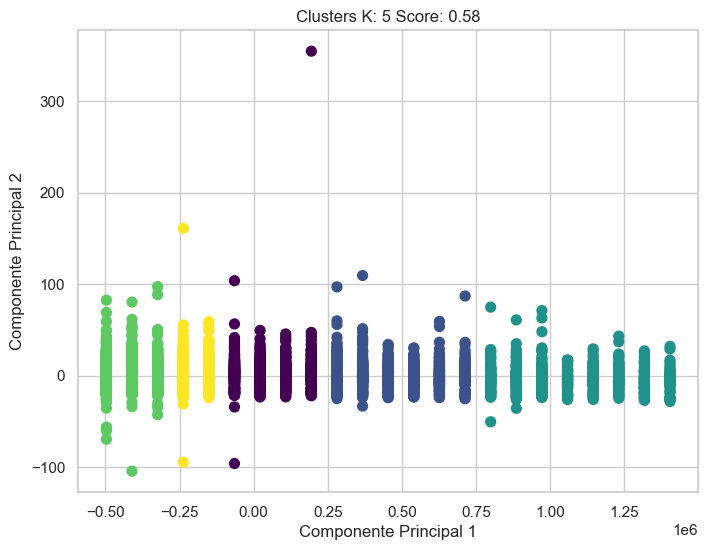

In [103]:
labels = kmeans.named_steps['kmeans'].labels_
PlotPCA(X, 5, labels)

Agora que vimos o KMeans com 5 classes, é preciso fazer os preparativos para achar o melhor K. Antes disso, foi criado essas classes para armazenar esse valor do melhor K.

In [32]:
class ScoreK:
    """
    Representa a relação entre o número de clusters (k) e o score de avaliação associado.
    
    Parâmetros:
    ----------
    k : int
        Número de clusters.
    score : float
        Score de avaliação associado ao número de clusters.
    """
    def __init__(self, k, score):
        self.k = k
        self.score = score

    def __repr__(self):
        return f"ScoreK(k='{self.k}', score='{self.score}')"


class BestK(ScoreK):
    """
    Representa o melhor número de clusters (k) e seu score, em comparação a um estado anterior.

    Parâmetros:
    ----------
    k : int
        Número de clusters atual.
    score : float
        Score de avaliação atual.
    last : ScoreK
        Instância de ScoreK representando o estado anterior para comparação.
    """
    def __init__(self,  k, score, last:ScoreK):
        super().__init__(k, score)
        self.last = last
        self.compare()

    
    def compare(self):
        if self.last.score >= self.score:
            self.k = self.last.k
            self.score = self.last.score

    
    def __repr__(self):
        return super().__repr__()


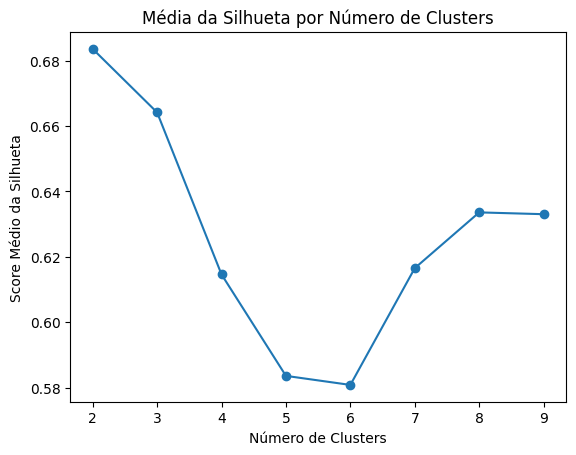

Melhor K: 2, Score: 0.68


In [33]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 10)
silhouette_scores = []
BEST_K = ScoreK(0,0)



for n_clusters in range_n_clusters:
    kmeans = make_pipeline(preprocessor, KMeans(n_clusters=n_clusters, random_state=42))
    kmeans.fit(df)
    score = silhouette_score(X, kmeans.named_steps['kmeans'].labels_)
    silhouette_scores.append(score)
    BEST_K = BestK(n_clusters, score, BEST_K)


plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Média da Silhueta por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Score Médio da Silhueta")
plt.show()

print(f'Melhor K: {BEST_K.k}, Score: {round(BEST_K.score, 2)}')



Dado o range de 2 - 9 o melhor parâmetro de K foi 2, que obteve um score no método da silhueta de 0.68 o qual representa uma boa classificação de Clusters

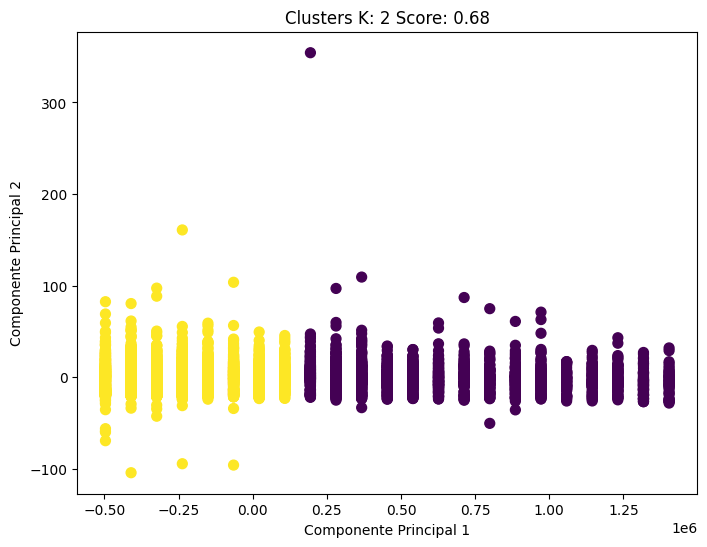

In [48]:
k = 2

kmeans = make_pipeline(preprocessor, KMeans(n_clusters=k, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


PlotPCA(X, k, labels)

Apesar de K=2 ser o melhor resultado, o estudo a seguir vai utilizar K=3, visto que não ocorre perdas significativas e também possibilita o estudo com uma quantidade de classes maior que a já existente de "Recomendado" e "Não recomendado".

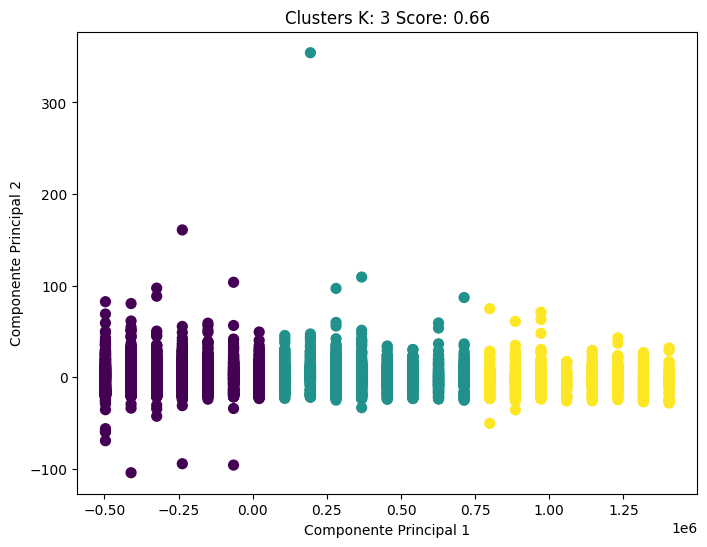

In [49]:
k = 3

kmeans = make_pipeline(preprocessor, KMeans(n_clusters=k, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


PlotPCA(X, k, labels)

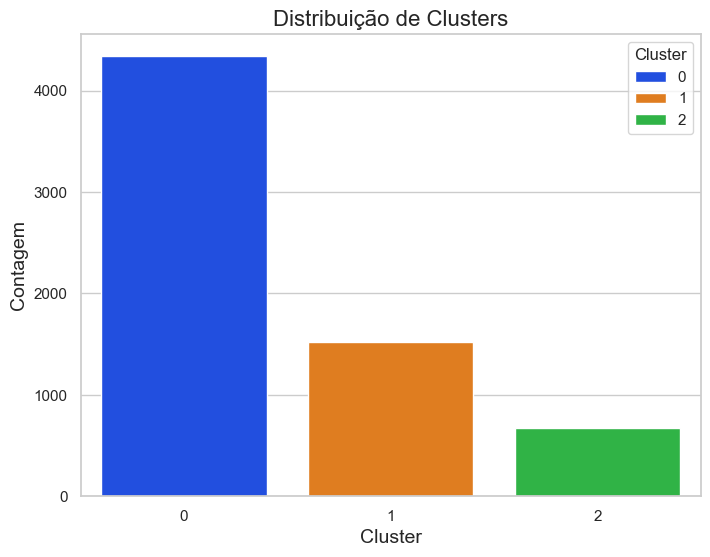

In [50]:
# Configurando o estilo do gráfico
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras laterais
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Cluster", hue="Cluster", palette="bright")
plt.title("Distribuição de Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Contagem", fontsize=14)

# Mostrando o gráfico
plt.show()

O gráfico demonstra que a grande quantidade dos registros se concentram na classe 0, enquanto que 1 e 2 somados, chegam aproximadamente a 1/3 de seu tamanho.

#### Clusters em relação a `label`


A seguir, pode ser visto como ficou a distribuição da classe `label` dentro dos 3 Clusters. O que pode se perceber, é que o Cluster 0 concentrou o maior volume de dados da classe `label`, representando tanto "recomendados" e "não recomendados".

Esse teste foi feito para analisar se algum cluster iria apresentar apenas o `label` 0 (não recomendados) ou uma concentração do valor,contudo, isso não ocorreu.

In [52]:
df.loc[df['Cluster'] == 0, 'label'].value_counts()

label
1    4147
0     192
Name: count, dtype: int64

In [53]:
df.loc[df['Cluster'] == 1, 'label'].value_counts()

label
1    1495
0      30
Name: count, dtype: int64

In [54]:
df.loc[df['Cluster'] == 2, 'label'].value_counts()

label
1    659
0     12
Name: count, dtype: int64

Para visualizar os registros de uma maneira mais legível que um DataFrame, foi criado a classe ShowReview.

In [63]:
class ShowReview:
    def __init__(self, quantidade_premios, horas_jogadas, data_publicacao, 
                recebeu_gratis, review_util, review_engracado, label, Cluster, texto_processado):
        self.quantidade_premios = quantidade_premios
        self.horas_jogadas = horas_jogadas
        self.data_publicacao = data_publicacao 
        self.recebeu_gratis = recebeu_gratis
        self.review_util = review_util
        self.review_engracado = review_engracado
        self.label = label
        self.Cluster = Cluster
        self.texto_processado = texto_processado

    def corpus_review(self, doc, break_line=60):
        words = doc.split(" ")
        string_faixa = ''
        corpus = ''

        for word in words:
            string_faixa += f'{word} '
            if len(string_faixa) >= break_line:
                corpus += string_faixa + '\n'
                string_faixa = ''
        corpus += string_faixa + '\n'
        
        return corpus


    def __str__(self):
        body = ''
        for key, value in self.__dict__.items():
            if key != 'texto_processado':
                body += f'{key:<70} {value}\n'
            else:
                body += '-' * 70 + '\n'
                body += "Texto da review:\n"
                body += '-' * 70 + '\n' 
                body += self.corpus_review(value)
                body += '-' * 70 + '\n'
        return body


A seguir, foi criado 3 sub-datasets para observar os valores de cada cluster e estudar suas diferenças.

In [75]:
cluster_0 = df.loc[df['Cluster'] == 0]
cluster_1 = df.loc[df['Cluster'] == 1]
cluster_2 = df.loc[df['Cluster'] == 2]


In [78]:
cluster_0.describe()


,quantidade_premios,horas_jogadas,data_publicacao,recebeu_gratis,review_util,review_engracado,label,Cluster
count,4339.000000,4339.000000,4339,4339.000000,4339.000000,4339.000000,4339.000000,4339.0
mean,0.065453,21.040631,2024-11-30 08:12:10.122148096,0.012215,1.486287,0.154183,0.955750,0.0
min,0.000000,0.100000,2024-11-28 00:00:00,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,9.200000,2024-11-29 00:00:00,0.000000,0.000000,0.000000,1.000000,0.0
50%,0.000000,21.400000,2024-11-30 00:00:00,0.000000,0.000000,0.000000,1.000000,0.0
75%,0.000000,28.900000,2024-12-02 00:00:00,0.000000,0.000000,0.000000,1.000000,0.0
max,35.000000,185.900000,2024-12-04 00:00:00,1.000000,521.000000,115.000000,1.000000,0.0
std,0.820357,13.839242,NaN,0.109856,16.436866,2.410971,0.205673,0.0


In [79]:
cluster_1.describe()


,quantidade_premios,horas_jogadas,data_publicacao,recebeu_gratis,review_util,review_engracado,label,Cluster
count,1525.000000,1525.000000,1525,1525.000000,1525.000000,1525.000000,1525.000000,1525.0
mean,0.024262,26.460000,2024-12-08 00:33:02.950819584,0.017705,0.436721,0.041967,0.980328,1.0
min,0.000000,0.300000,2024-12-05 00:00:00,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,18.400000,2024-12-06 00:00:00,0.000000,0.000000,0.000000,1.000000,1.0
50%,0.000000,25.400000,2024-12-08 00:00:00,0.000000,0.000000,0.000000,1.000000,1.0
75%,0.000000,33.300000,2024-12-10 00:00:00,0.000000,0.000000,0.000000,1.000000,1.0
max,5.000000,385.600000,2024-12-12 00:00:00,1.000000,142.000000,8.000000,1.000000,1.0
std,0.217511,16.490965,NaN,0.131920,4.050788,0.331340,0.138916,0.0


In [80]:
cluster_2.describe() 


,quantidade_premios,horas_jogadas,data_publicacao,recebeu_gratis,review_util,review_engracado,label,Cluster
count,671.000000,671.000000,671,671.000000,671.000000,671.000000,671.000000,671.0
mean,0.052161,25.263636,2024-12-16 01:30:08.047690240,0.028316,0.716841,0.147541,0.982116,2.0
min,0.000000,0.300000,2024-12-13 00:00:00,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.000000,17.450000,2024-12-14 00:00:00,0.000000,0.000000,0.000000,1.000000,2.0
50%,0.000000,24.400000,2024-12-16 00:00:00,0.000000,0.000000,0.000000,1.000000,2.0
75%,0.000000,32.450000,2024-12-18 00:00:00,0.000000,0.000000,0.000000,1.000000,2.0
max,11.000000,103.000000,2024-12-20 00:00:00,1.000000,203.000000,56.000000,1.000000,2.0
std,0.602451,13.853497,NaN,0.165998,8.298372,2.247517,0.132628,0.0


Ao observar apenas os dados numéricos, os clusters não apresentaram tantas diferenças entre sí, apenas uma variação pequena nas features `horas_jogadas` e `data_publicacao`. Isso pode significar que grande parte da clusterização se dá por conta das do conteúdo textual da review, na feature `texto_processado`.

A seguir, é demonstrado uma amostra de registros contidos em cada cluster:

In [61]:
columns_show_review = ['quantidade_premios', 'horas_jogadas', 'data_publicacao','recebeu_gratis', 'review_util', 'review_engracado', 'label', 'Cluster', 'texto_processado']

In [67]:
for i in cluster_0[:10].index:
    print(ShowReview(*cluster_0.loc[i, columns_show_review]),'\n')



quantidade_premios                                                     0
horas_jogadas                                                          29.8
data_publicacao                                                        2024-12-04 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                0
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
E então o cara entrou em um servidor de Minecraft, fez um litro 
de coisas lá dentro apenas para promover o seu próprio jogo. 
É bizarro. 
----------------------------------------------------------------------
 

quantidade_premios     

In [68]:
for i in cluster_1[:10].index:
    print(ShowReview(*cluster_1.loc[i, columns_show_review]),'\n')

quantidade_premios                                                     0
horas_jogadas                                                          20.4
data_publicacao                                                        2024-12-12 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                1
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
Que jogo incrível, esperei quatro anos por essa bomba, mas no 
final valeu a pena. Cada hora que eu perdi tentando resolver 
cada enigma foi maravilhosa. Bati em morto, cego e até espírito. 
(Não jogue no modo detetive caso tenha um QI 

In [69]:
for i in cluster_2[:10].index:
    print(ShowReview(*cluster_2.loc[i, columns_show_review]),'\n')


quantidade_premios                                                     0
horas_jogadas                                                          37.4
data_publicacao                                                        2024-12-20 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                2
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
A investigação é incrível e a história é absurda da boa, eu 
recomendo muito que todos experimentem essa história. Mas infelizmente 
nem tudo pode ser perfeito, e para mim a gameplay foi algo que 
pecou bastante ao longo da jogatina, os

## Revisar

In [104]:
from sklearn.cluster import DBSCAN

dbscan = make_pipeline(preprocessor, DBSCAN(eps=0.65, min_samples=5, metric='cosine'))  # Configurações importantes
dbscan.fit_predict(df)

array([0, 0, 0, ..., 0, 0, 0], shape=(6535,))

Score médio da Silhueta: -0.294


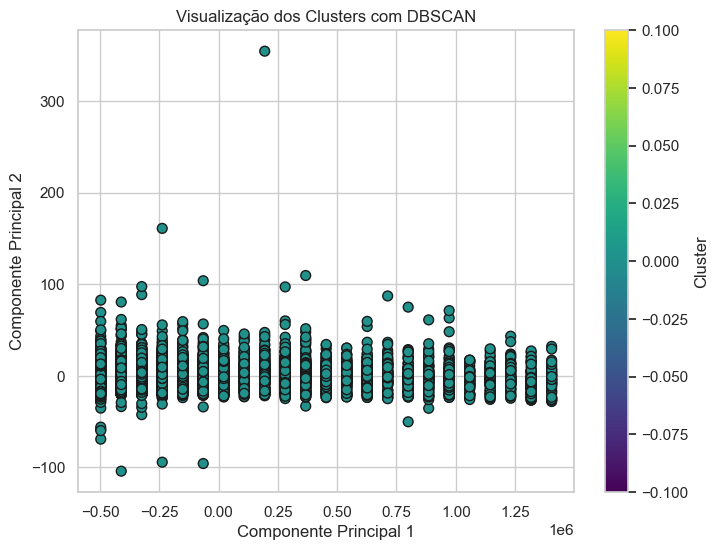

In [105]:


# Adicionar os rótulos ao DataFrame
df["Cluster"] = dbscan.named_steps['dbscan'].labels_

# 4. Avaliar os resultados
# Calcular o score médio da silhueta (exclui os pontos ruidosos - cluster -1)
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels, metric='cosine')
    print(f"Score médio da Silhueta: {silhouette_avg:.3f}")
else:
    print("Não foi possível calcular o score da silhueta (apenas um cluster ou todos são ruídos).")

# 5. Visualizar os clusters usando PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df["Cluster"],
    cmap='viridis',
    s=50,
    edgecolor='k'
)
plt.title("Visualização dos Clusters com DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()


In [108]:
df["Cluster"].value_counts()

Cluster
0    6535
Name: count, dtype: int64

Não foi possível calcular o score da silhueta (apenas um cluster ou todos são ruídos).


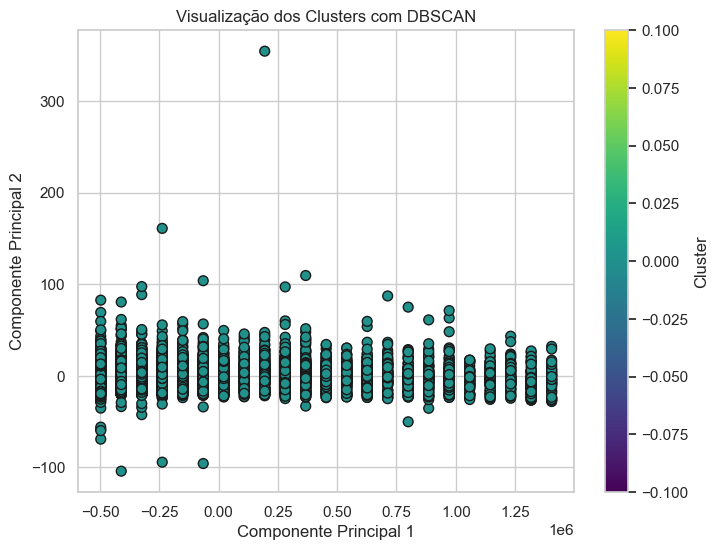

In [106]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')  # Configurações importantes
labels = dbscan.fit_predict(X)

# Adicionar os rótulos ao DataFrame
df["Cluster"] = labels

# 4. Avaliar os resultados
# Calcular o score médio da silhueta (exclui os pontos ruidosos - cluster -1)
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels, metric='cosine')
    print(f"Score médio da Silhueta: {silhouette_avg:.3f}")
else:
    print("Não foi possível calcular o score da silhueta (apenas um cluster ou todos são ruídos).")

# 5. Visualizar os clusters usando PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df["Cluster"],
    cmap='viridis',
    s=50,
    edgecolor='k'
)
plt.title("Visualização dos Clusters com DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()
